In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import re, difflib

df = pd.read_csv("../Traffic_Violations.csv")
df.head()

/var/folders/pn/4y4l36bj63dcxqbj4q9h21n80000gn/T/ipykernel_42497/499923635.py:8: DtypeWarning: Columns (26) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("../Traffic_Violations.csv")


,Date Of Stop,Time Of Stop,Agency,SubAgency,Description,Location,Latitude,Longitude,Accident,Belts,...,Charge,Article,Contributed To Accident,Race,Gender,Driver City,Driver State,DL State,Arrest Type,Geolocation
0,09/24/2013,17:11:00,MCP,"3rd district, Silver Spring",DRIVING VEHICLE ON HIGHWAY WITH SUSPENDED REGI...,8804 FLOWER AVE,NaN,NaN,No,No,...,13-401(h),Transportation Article,No,BLACK,M,TAKOMA PARK,MD,MD,A - Marked Patrol,NaN
1,12/20/2012,00:41:00,MCP,"2nd district, Bethesda",DRIVING WHILE IMPAIRED BY ALCOHOL,NORFOLK AVE / ST ELMO AVE,38.983578,-77.093105,No,No,...,21-902(b1),Transportation Article,No,WHITE,M,DERWOOD,MD,MD,A - Marked Patrol,"(38.9835782, -77.09310515)"
2,07/20/2012,23:12:00,MCP,"5th district, Germantown",FAILURE TO STOP AT STOP SIGN,WISTERIA DR @ WARING STATION RD,39.161810,-77.253581,No,No,...,21-707(a),Transportation Article,No,ASIAN,F,GERMANTOWN,MD,MD,A - Marked Patrol,"(39.1618098166667, -77.25358095)"
3,03/19/2012,16:10:00,MCP,"2nd district, Bethesda",DRIVER USING HANDS TO USE HANDHELD TELEPHONE W...,CLARENDON RD @ ELM ST. N/,38.982731,-77.100755,No,No,...,21-1124.2(d2),Transportation Article,No,HISPANIC,M,ARLINGTON,VA,VA,A - Marked Patrol,"(38.9827307333333, -77.1007551666667)"
4,12/01/2014,12:52:00,MCP,"6th district, Gaithersburg / Montgomery Village",FAILURE STOP AND YIELD AT THRU HWY,CHRISTOPHER AVE/MONTGOMERY VILLAGE AVE,39.162888,-77.229088,No,No,...,21-403(b),Transportation Article,No,BLACK,F,UPPER MARLBORO,MD,MD,A - Marked Patrol,"(39.1628883333333, -77.2290883333333)"


In [7]:
df.info()
df.isna().sum().sort_values(ascending=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1018634 entries, 0 to 1018633
Data columns (total 35 columns):
 #   Column                   Non-Null Count    Dtype  
---  ------                   --------------    -----  
 0   Date Of Stop             1018634 non-null  object 
 1   Time Of Stop             1018634 non-null  object 
 2   Agency                   1018634 non-null  object 
 3   SubAgency                1018634 non-null  object 
 4   Description              1018625 non-null  object 
 5   Location                 1018632 non-null  object 
 6   Latitude                 933599 non-null   float64
 7   Longitude                933599 non-null   float64
 8   Accident                 1018634 non-null  object 
 9   Belts                    1018634 non-null  object 
 10  Personal Injury          1018634 non-null  object 
 11  Property Damage          1018634 non-null  object 
 12  Fatal                    1018634 non-null  object 
 13  Commercial License       1018634 non-null 

Geolocation                85035
Latitude                   85035
Longitude                  85035
Article                    52065
Color                      13591
Year                        6426
DL State                     929
Model                        169
Driver City                  141
State                         59
Make                          48
Driver State                  11
Description                    9
Location                       2
Race                           0
Contributed To Accident        0
Charge                         0
Violation Type                 0
Arrest Type                    0
Gender                         0
Date Of Stop                   0
VehicleType                    0
Time Of Stop                   0
Alcohol                        0
Commercial Vehicle             0
HAZMAT                         0
Commercial License             0
Fatal                          0
Property Damage                0
Personal Injury                0
Belts     

It seems that we don't have many missing values compares to the million rows of the dataset. Additionally, some of the missing data doesn't appear to be incredibly important or may in fact be missing on purpose. For example, car color may be missing due to jaywalking violations.

In [5]:
print("Most recent date:", df["Date Of Stop"].max())
print("Least recent date:", df["Date Of Stop"].min())
print("Latest time:", df["Time Of Stop"].max())
print("Earliest time:", df["Time Of Stop"].min())


Most recent date: 12/31/2015
Least recent date: 01/01/2012
Latest time: 23:59:00
Earliest time: 00:00:00


we have data from the very beginning of 2012 to the end of 2015

In [8]:
print(df["Agency"].unique())
print(df["SubAgency"].nunique())
print(df["SubAgency"].unique())
df.groupby("SubAgency").size().sort_values(ascending=False)


['MCP']
7
['3rd district, Silver Spring' '2nd district, Bethesda'
 '5th district, Germantown'
 '6th district, Gaithersburg / Montgomery Village' '4th district, Wheaton'
 '1st district, Rockville' 'Headquarters and Special Operations']


SubAgency
4th district, Wheaton                              248696
3rd district, Silver Spring                        212326
2nd district, Bethesda                             149805
6th district, Gaithersburg / Montgomery Village    137326
1st district, Rockville                            119765
5th district, Germantown                           115052
Headquarters and Special Operations                 35664
dtype: int64

We have a limited number of subagencies, this should make it easy to break down citation rates by district/town.

In [12]:
geo_df = df[["Latitude","Longitude"]].dropna().sample(8000,random_state=42)

px.scatter_map(
    geo_df,
    lat="Latitude",
    lon="Longitude",
    title="Overall Stop Density"
)


This dataset appears to be specific to the Montgomery county in Maryland, and the immediate sorroundings.

# Data Cleaning

Most of the dataset appears fairly clean. Mostly categorical and boolean values, legal jargon, text descriptions that can't really be cleaned in any meaningful way. The vehicle information is the area that needs the most cleanup. Cleaning up the car make is fairly straighforward.

In [13]:
canonical_makes = [
    "ACURA","ALFA ROMEO","ASTON MARTIN","AUDI","BENTLEY","BMW","BUGATTI","BUICK",
    "CADILLAC","CHEVROLET","CHRYSLER","DODGE","FERRARI","FIAT","FORD","GENESIS","GMC",
    "HONDA","HUMMER","HYUNDAI","INFINITI","ISUZU","JAGUAR","JEEP","KIA","LAMBORGHINI",
    "LAND ROVER","LEXUS","LINCOLN","MASERATI","MAZDA","MERCEDES-BENZ","MERCURY","MINI",
    "MITSUBISHI","NISSAN","OLDSMOBILE","PEUGEOT","PLYMOUTH","PONTIAC","PORSCHE","RAM",
    "RENAULT","ROLLS-ROYCE","SAAB","SATURN","SCION","SMART","SUBARU","SUZUKI","TESLA",
    "TOYOTA","VOLKSWAGEN","VOLVO",
    "MACK","FREIGHTLINER","PETERBILT","KENWORTH","HINO","INTERNATIONAL",
    "HARLEY DAVIDSON","KAWASAKI","YAMAHA",
    "NONE","NA",
]

alias_map = {
    "TOYOT":"TOYOTA","TOYTA":"TOYOTA","TOYO":"TOYOTA","TOYT":"TOYOTA","TOTY":"TOYOTA","TYT":"TOYOTA",
    "HYANDAI":"HYUNDAI","HYUNDIA":"HYUNDAI","HYUNDI":"HYUNDAI","HYND":"HYUNDAI",
    "MERC":"MERCEDES-BENZ","MERZ":"MERCEDES-BENZ","MERZ BENZ":"MERCEDES-BENZ",
    "MB":"MERCEDES-BENZ","M B":"MERCEDES-BENZ","M-B":"MERCEDES-BENZ","BENZ":"MERCEDES-BENZ",
    "MERCEDES":"MERCEDES-BENZ","MERCEDES BENZ":"MERCEDES-BENZ","MERCDES":"MERCEDES-BENZ",
    "CHEV":"CHEVROLET","CHEVY":"CHEVROLET","CHEVEROLET":"CHEVROLET","CHV":"CHEVROLET","CHE":"CHEVROLET",
    "INF":"INFINITI","INFINITY":"INFINITI","INFIN":"INFINITI",
    "LEX":"LEXUS","LEXSUS":"LEXUS","LEXS":"LEXUS",
    "MITS":"MITSUBISHI","MITZ":"MITSUBISHI","MITUSBISHI":"MITSUBISHI","MISUBISHI":"MITSUBISHI",
    "MITUBISHI":"MITSUBISHI","MITUSB":"MITSUBISHI",
    "OLDS":"OLDSMOBILE","OLDSMOB":"OLDSMOBILE","OLDSM":"OLDSMOBILE",
    "LNDR":"LAND ROVER","RANG":"LAND ROVER","RANGE":"LAND ROVER","RANGE ROVER":"LAND ROVER","LANDROVER":"LAND ROVER",
    "DODG":"DODGE","CRYSLER":"CHRYSLER","CHRSYLER":"CHRYSLER","CHR":"CHRYSLER",
    "HOND":"HONDA","HON":"HONDA",
    "VW":"VOLKSWAGEN","VOLKS":"VOLKSWAGEN","VOLKSWAGON":"VOLKSWAGEN","WOLKSWAGEN":"VOLKSWAGEN",
    "CAD":"CADILLAC","CADI":"CADILLAC","CADDY":"CADILLAC",
    "NIS":"NISSAN","NISN":"NISSAN","NISS":"NISSAN",
    "SUB":"SUBARU","SUBA":"SUBARU",
    "FRD":"FORD","FD":"FORD",
    "GM":"GMC","G M C":"GMC",
    "MAZD":"MAZDA",
    "GEN":"GENESIS","GENSIS":"GENESIS",
    "PORSHE":"PORSCHE","POR":"PORSCHE",
    "TSLA":"TESLA",
    "HARLEY":"HARLEY DAVIDSON","HARLEY-DAVIDSON":"HARLEY DAVIDSON","HARL":"HARLEY DAVIDSON",
    "YAMA":"YAMAHA","YAM":"YAMAHA",
    "KAW":"KAWASAKI","KAWK":"KAWASAKI",
}

def normalize_make(x):
    if not isinstance(x,str): return ""
    s = x.upper().strip()
    s = re.sub(r"[^\w\s]"," ",s)
    s = re.sub(r"\s+"," ",s)
    return s

def resolve_make(raw):
    s = normalize_make(raw)
    if not s: return "UNKNOWN"
    if s in alias_map: return alias_map[s]
    if s in canonical_makes: return s
    first = s.split(" ")[0]
    if first in alias_map: return alias_map[first]
    match = difflib.get_close_matches(s, canonical_makes, n=1, cutoff=0.65)
    if match: return match[0]
    match = difflib.get_close_matches(first, canonical_makes, n=1, cutoff=0.65)
    return match[0] if match else "UNKNOWN"


In [17]:
df["Cleaned_Make"] = df["Make"].apply(resolve_make)

print("Before:", df["Make"].nunique())
print("After:", df["Cleaned_Make"].nunique())


Before: 3129
After: 64


In [18]:
display(df["Cleaned_Make"].value_counts().head(20))
display(df[df["Cleaned_Make"]=="UNKNOWN"]["Make"].value_counts().head(20))

Cleaned_Make
TOYOTA           176134
HONDA            146098
FORD              97400
CHEVROLET         79986
NISSAN            77116
DODGE             35389
ACURA             31806
HYUNDAI           31411
MERCEDES-BENZ     30929
BMW               28035
LEXUS             22893
JEEP              22318
MAZDA             20534
VOLVO             18326
CHRYSLER          17570
VOLKSWAGEN        15194
MITSUBISHI        13825
GMC               13774
SUBARU            13696
KIA               12617
Name: count, dtype: int64

Make
GEO         677
INTL        664
FRHT        346
PETE        162
FREI        146
STERLING    138
INTE        115
TAO TAO     102
LAND         97
PTRB         95
KW           95
THOMAS       87
CARR         84
DUCATI       71
GILL         70
ORION        63
STER         58
HUYN         58
KYMCO        58
PREM         57
Name: count, dtype: int64

With the cleanup we managed to go from 3129 values to 64. There are only 2,000 rows now (out of a million) which have values that don't map nicely to a well known vehicle make

# EDA

C:\Users\diazk\AppData\Local\Temp\ipykernel_24352\3114062182.py:1: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.



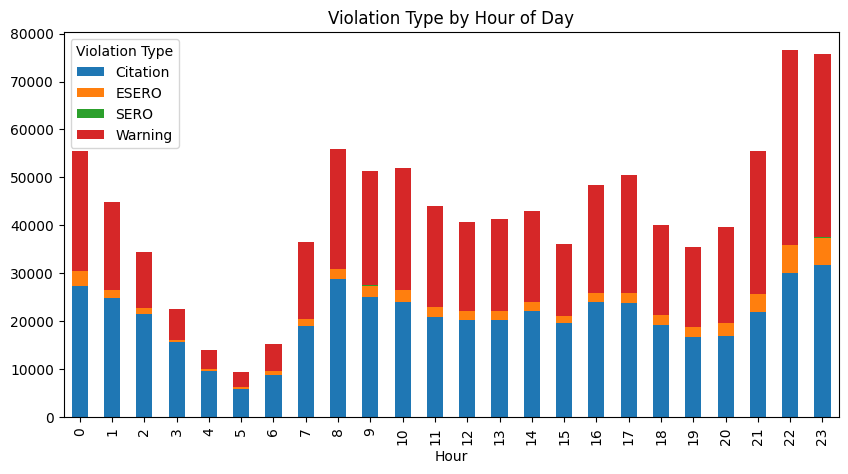

In [23]:
df["Hour"] = pd.to_datetime(df["Time Of Stop"], errors="coerce").dt.hour

hourly = df.groupby(["Hour","Violation Type"]).size().unstack(fill_value=0)
hourly.plot(kind="bar", stacked=True, figsize=(10,5))
plt.title("Violation Type by Hour of Day")
plt.show()

We see most traffic violations are occuring late at night/early morning. Surprisingly, it is also on those days that higher proportions of warnings are given out. In the mornings there are fewer traffic stops over all, but they are more likely to result in citations.

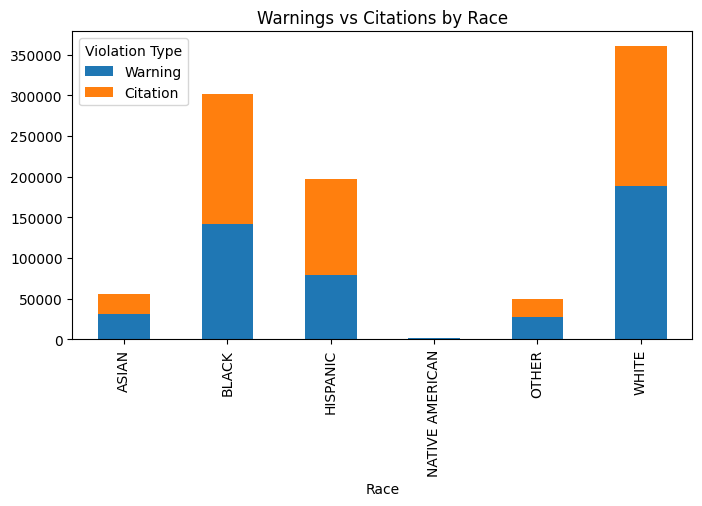

In [24]:
race_outcomes = df.groupby("Race")["Violation Type"].value_counts().unstack()
race_outcomes[["Warning","Citation"]].plot(kind="bar", stacked=True, figsize=(8,4))
plt.title("Warnings vs Citations by Race")
plt.show()

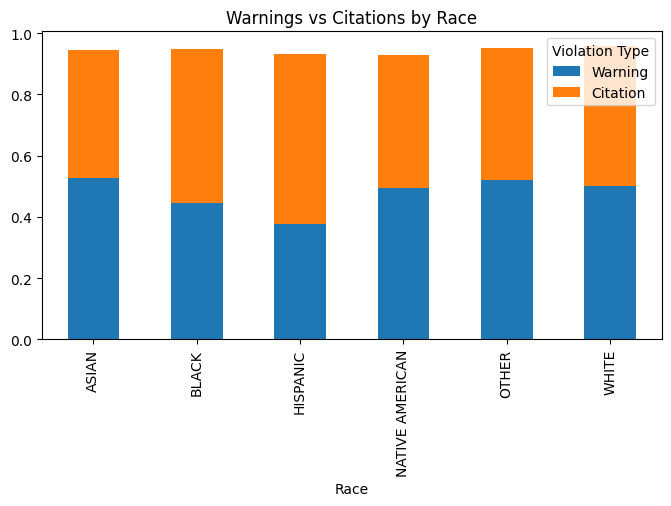

In [25]:
race_outcomes = df.groupby("Race")["Violation Type"].value_counts(normalize=True).unstack()
race_outcomes[["Warning","Citation"]].plot(kind="bar", stacked=True, figsize=(8,4))
plt.title("Warnings vs Citations by Race")
plt.show()

These numbers seem to imply there is some racial bias in citations vs warnings. We don't have included demographic information in the dataset, but it seems that Montgomery county is majority white.

Still, Black and Hispanic people receive a sizeable share of the traffic stops, and traffic stops are more likely to result in citations rather than warnings.

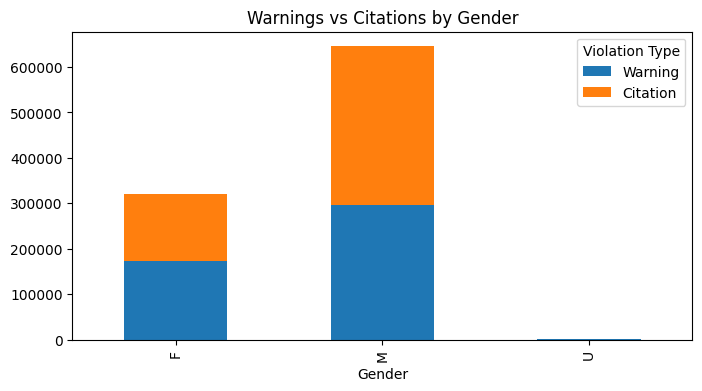

In [27]:
gender_outcomes = df.groupby("Gender")["Violation Type"].value_counts().unstack()
gender_outcomes[["Warning","Citation"]].plot(kind="bar", stacked=True, figsize=(8,4))
plt.title("Warnings vs Citations by Gender")
plt.show()

Interestingly, women are stopped almost half as frequently as men. Proportion-wise, men receive more citations than warnings while it is the opposite for women

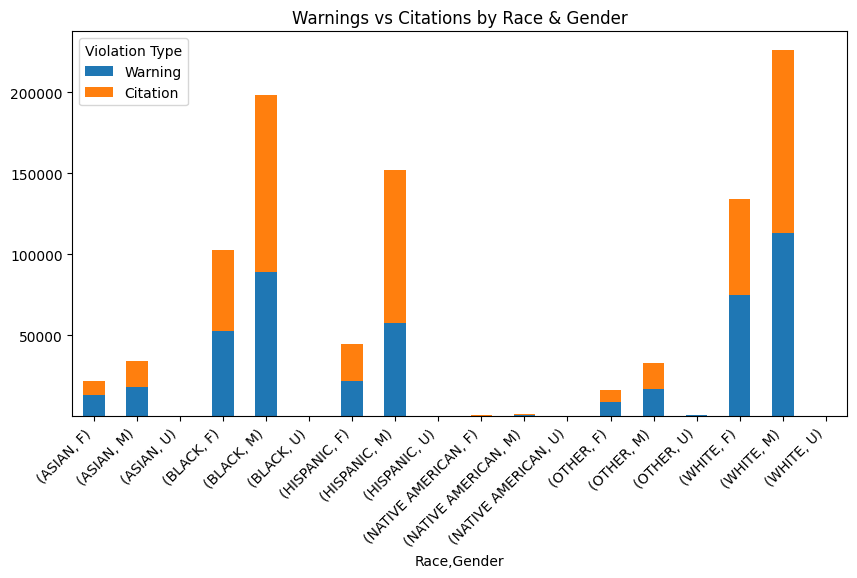

In [28]:
race_gender = pd.crosstab([df["Race"],df["Gender"]], df["Violation Type"])
race_gender[["Warning","Citation"]].plot(kind="bar", stacked=True, figsize=(10,5))
plt.title("Warnings vs Citations by Race & Gender")
plt.xticks(rotation=45, ha="right")
plt.show()


For some intersectionality analysis, it seems that Hispanic men are the group that is the worst off

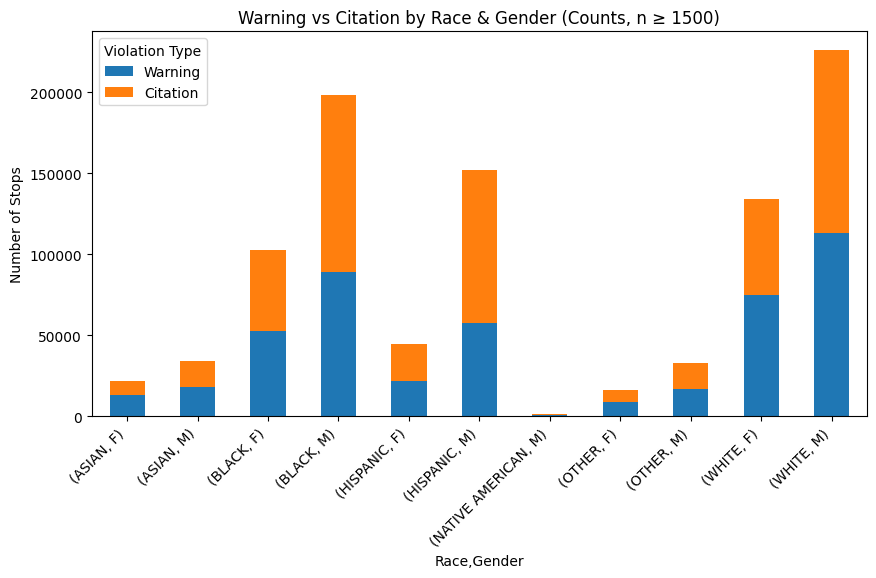

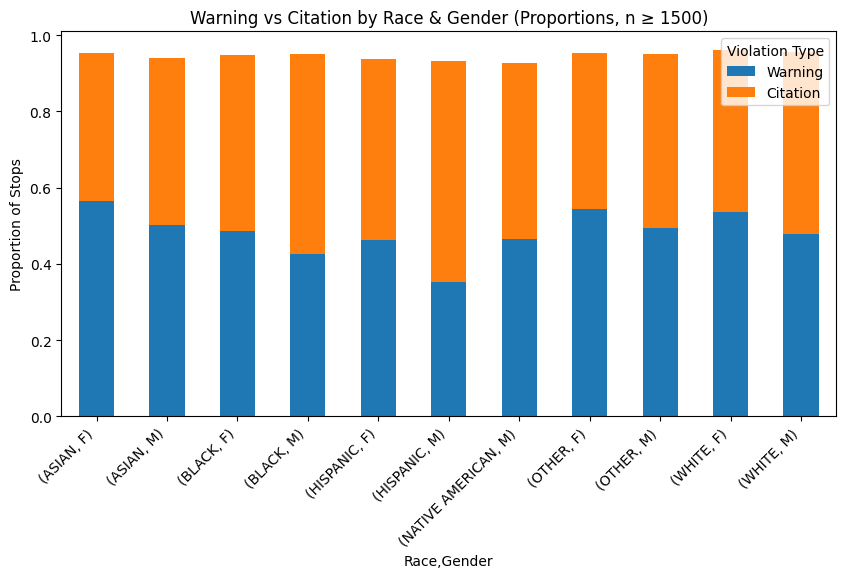

,Violation Type,Warning,Citation
Race,Gender,,
HISPANIC,M,0.351930,0.580273
BLACK,M,0.425266,0.524627
WHITE,M,0.478057,0.478069
HISPANIC,F,0.463538,0.473631
NATIVE AMERICAN,M,0.464763,0.462940
BLACK,F,0.486974,0.459706
OTHER,M,0.494721,0.455297
ASIAN,M,0.503193,0.435921
WHITE,F,0.537001,0.424634


In [35]:
MIN_SAMPLES = 1500

# --- Raw counts ---
race_gender_counts = pd.crosstab(
    [df["Race"], df["Gender"]],
    df["Violation Type"]
)

# Add a total count column
race_gender_counts["Total"] = race_gender_counts.sum(axis=1)

# Filter groups with enough samples
filtered_counts = race_gender_counts[race_gender_counts["Total"] >= MIN_SAMPLES]

# Plot counts
filtered_counts[["Warning", "Citation"]].plot(
    kind="bar",
    stacked=True,
    figsize=(10,5),
    title=f"Warning vs Citation by Race & Gender (Counts, n ≥ {MIN_SAMPLES})"
)
plt.xticks(rotation=45, ha="right")
plt.ylabel("Number of Stops")
plt.show()

# --- Normalized proportions ---
filtered_props = filtered_counts[["Warning","Citation"]].div(
    filtered_counts["Total"], axis=0
)

filtered_props.plot(
    kind="bar",
    stacked=True,
    figsize=(10,5),
    title=f"Warning vs Citation by Race & Gender (Proportions, n ≥ {MIN_SAMPLES})"
)
plt.xticks(rotation=45, ha="right")
plt.ylabel("Proportion of Stops")
plt.show()

# Show the filtered proportion table
filtered_props.sort_values(by="Citation", ascending=False)


It seems that Hispanic men are the worst off, with a 58% citation rate. Followed by Black men with a 52% citation rate

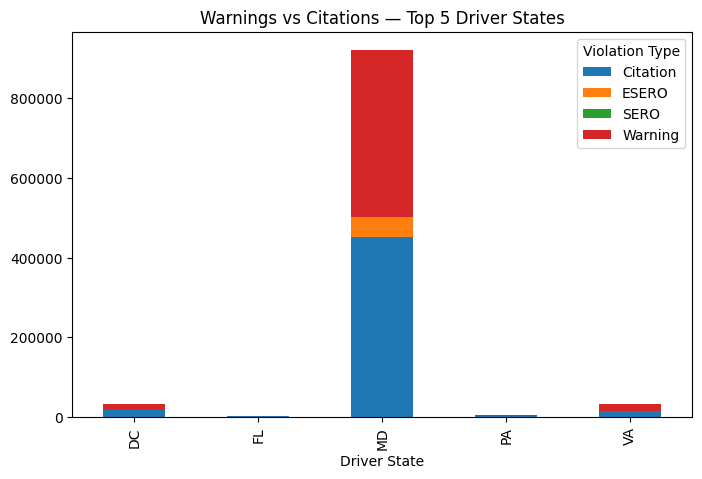

In [36]:
top_states = df["Driver State"].value_counts().head(5).index
subset = df[df["Driver State"].isin(top_states)]

state_counts = subset.groupby(["Driver State","Violation Type"]).size().unstack(fill_value=0)

state_counts.plot(kind="bar", stacked=True, figsize=(8,5))
plt.title("Warnings vs Citations — Top 5 Driver States")
plt.show()


The vast majority of drivers being stopped are Maryland natives. The driver's state doesn't seem to have much of an effect. It makes sense, since there is no way to know this before making the stop.

In [7]:
# --- Aggregate counts ---
charge_counts = df.groupby(["Charge","Violation Type"]).size().unstack(fill_value=0)
charge_counts["Total"] = charge_counts.sum(axis=1)
charge_counts["Pct_Citation"] = charge_counts["Citation"] / charge_counts["Total"]

# --- Attach a description for each charge (pick first non-null) ---
desc_map = (
    df.dropna(subset=["Charge","Description"])
      .groupby("Charge")["Description"]
      .first()
)

# Merge descriptions into the main table
charge_counts = charge_counts.merge(
    desc_map,
    left_index=True,
    right_index=True,
    how="left"
)

# Sort by total
top10 = charge_counts.sort_values("Total", ascending=False).head(10)

pd.set_option('display.max_colwidth', None)

# Display the full table for the top 10
top10[['Pct_Citation', 'Description']]

,Pct_Citation,Description
Charge,,
21-801.1,0.540974,EXCEEDING MAXIMUM SPEED: 49 MPH IN A POSTED 40 MPH ZONE
21-201(a1),0.340363,DRIVER FAILURE TO OBEY PROPERLY PLACED TRAFFIC CONTROL DEVICE INSTRUCTIONS
13-409(b),0.361111,FAILURE TO DISPLAY REGISTRATION CARD UPON DEMAND BY POLICE OFFICER
13-401(h),0.494918,DRIVING VEHICLE ON HIGHWAY WITH SUSPENDED REGISTRATION
21-707(a),0.282265,FAILURE TO STOP AT STOP SIGN
16-101(a),0.939583,DRIVING MOTOR VEHICLE ON HIGHWAY WITHOUT REQUIRED LICENSE AND AUTHORIZATION
16-112(c),0.679827,FAILURE OF INDIVIDUAL DRIVING ON HIGHWAY TO DISPLAY LICENSE TO UNIFORMED POLICE ON DEMAND
16-303(h),0.978953,"PERSON DRIVING MOTOR VEHICLE WHILE LICENSE SUSPENDED UNDER 17-106, 26-204, 26-206, 27-103"
13-411(f),0.413536,DISPLAYING EXPIRED REGISTRATION PLATE ISSUED BY ANY STATE


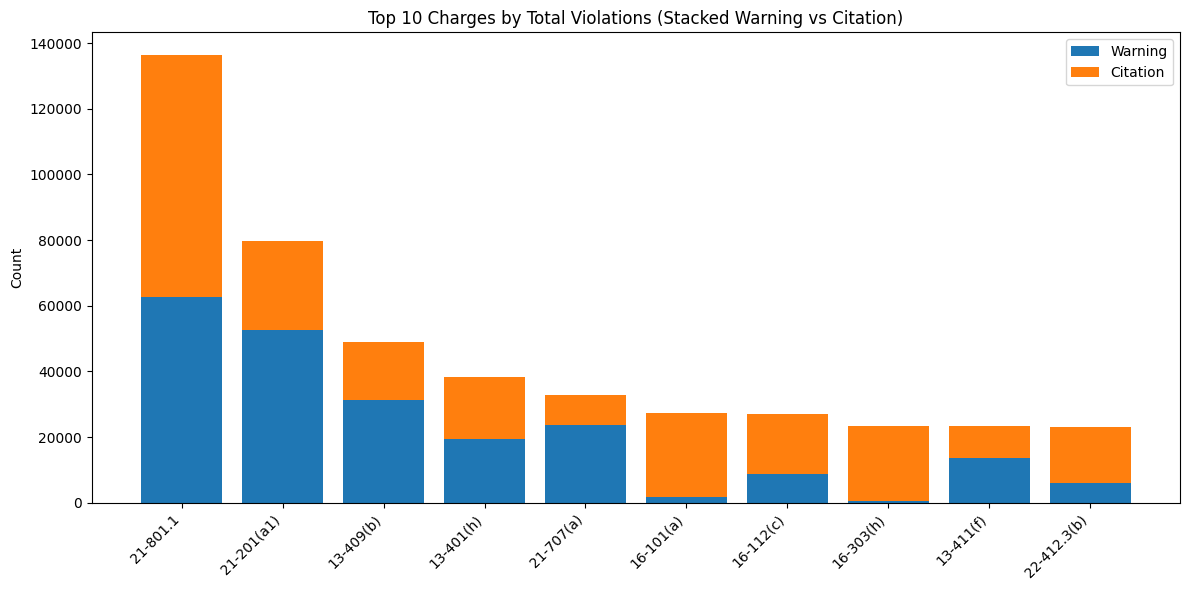

In [42]:
# Sort top 10 charges by total (already created in previous cell)
top10_sorted = top10.sort_values("Total", ascending=False)

# Plot stacked bar chart
plt.figure(figsize=(12,6))
plt.bar(top10_sorted.index.astype(str), top10_sorted["Warning"], label="Warning")
plt.bar(top10_sorted.index.astype(str), top10_sorted["Citation"], 
        bottom=top10_sorted["Warning"], label="Citation")

plt.xticks(rotation=45, ha="right")
plt.title("Top 10 Charges by Total Violations (Stacked Warning vs Citation)")
plt.ylabel("Count")
plt.legend()
plt.tight_layout()
plt.show()


It seems speeding is the most common charge (21-801.1). It is also fairly evenly split between citation and warning. It will be interesting to try and figure out what the difference is between cases that result in a warning vs a citation. We may or may not have enough information in this dataset. Critically, we are missing the driver's record.

In [39]:
dui = df[df["Charge"].astype(str).str.startswith("21-902")]
print("Total DUI charges:", len(dui))
print(dui["Violation Type"].value_counts(normalize=True))


Total DUI charges: 37192
Violation Type
Citation    0.994461
Warning     0.005539
Name: proportion, dtype: float64


a DUI (charges under section 21-902) is almost certainly a citation. It would be interesting to see where the handful of warnings is coming from.

C:\Users\diazk\AppData\Local\Temp\ipykernel_24352\1868081694.py:3: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.



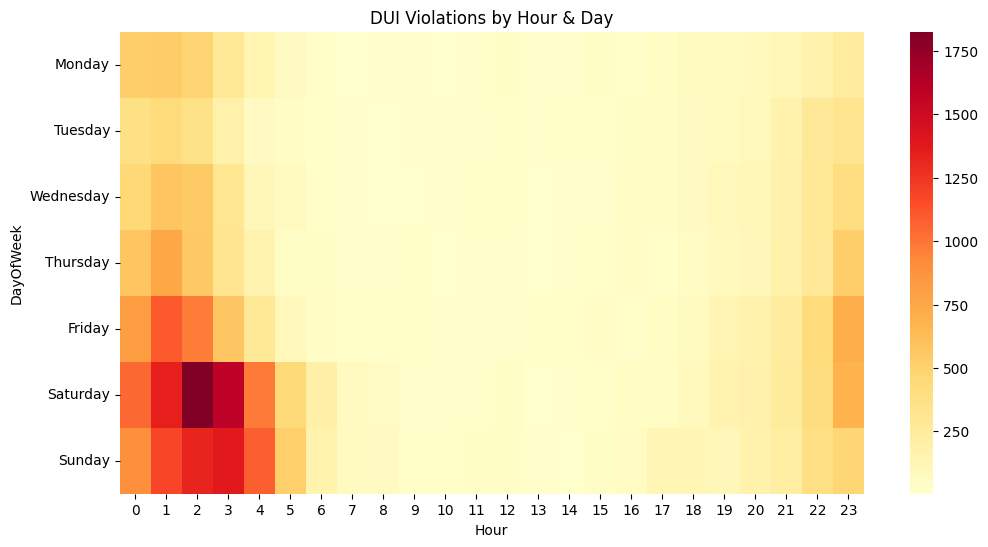

In [43]:
dui2 = dui.copy()
dui2["Date Of Stop"] = pd.to_datetime(dui2["Date Of Stop"], errors="coerce")
dui2["Time Of Stop"] = pd.to_datetime(dui2["Time Of Stop"], errors="coerce")
dui2["Hour"] = dui2["Time Of Stop"].dt.hour
dui2["DayOfWeek"] = dui2["Date Of Stop"].dt.day_name()

vol = dui2.groupby(["DayOfWeek","Hour"]).size().reset_index(name="Count")

order = ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]
vol["DayOfWeek"] = pd.Categorical(vol["DayOfWeek"], categories=order, ordered=True)

heat = vol.pivot(index="DayOfWeek", columns="Hour", values="Count")

plt.figure(figsize=(12,6))
sns.heatmap(heat, cmap="YlOrRd")
plt.title("DUI Violations by Hour & Day")
plt.show()


Predictably, DUIs are happening late night/early morning on the weekends.

C:\Users\diazk\AppData\Local\Temp\ipykernel_24352\2554612235.py:6: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.

C:\Users\diazk\AppData\Local\Temp\ipykernel_24352\2554612235.py:16: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



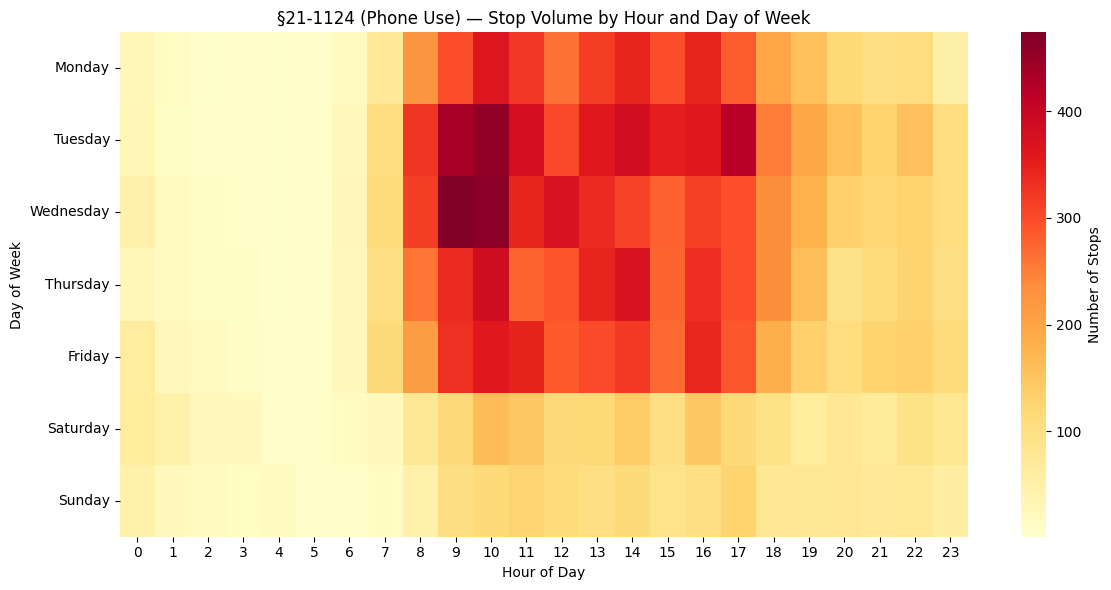

C:\Users\diazk\AppData\Local\Temp\ipykernel_24352\2554612235.py:35: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



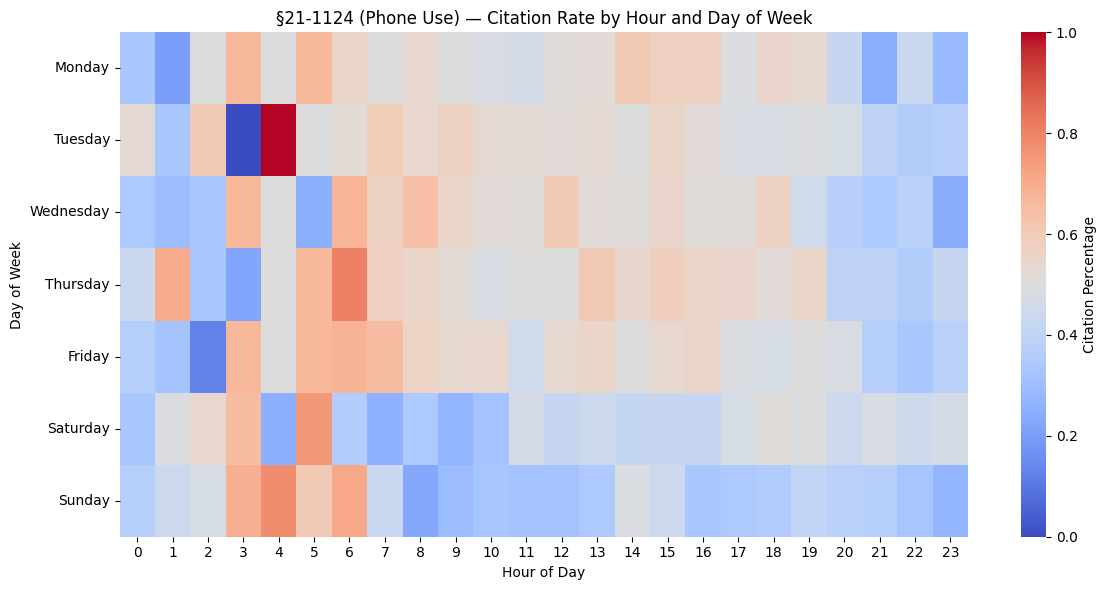

In [46]:
# --- Filter phone-related charges (21-1124) ---
mobile = df[df["Charge"].astype(str).str.startswith("21-1124")].copy()

# --- Extract date/time pieces ---
mobile["Date Of Stop"] = pd.to_datetime(mobile["Date Of Stop"], errors="coerce")
mobile["Time Of Stop"] = pd.to_datetime(mobile["Time Of Stop"], errors="coerce")
mobile["Hour"] = mobile["Time Of Stop"].dt.hour
mobile["DayOfWeek"] = mobile["Date Of Stop"].dt.day_name()

# Order weekdays
day_order = ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]
mobile["DayOfWeek"] = pd.Categorical(mobile["DayOfWeek"], categories=day_order, ordered=True)

# --- 1. Volume (raw count of stops) ---
volume = (
    mobile.groupby(["DayOfWeek","Hour"])
    .size()
    .reset_index(name="Count")
)

volume_matrix = volume.pivot(index="DayOfWeek", columns="Hour", values="Count")

plt.figure(figsize=(12,6))
sns.heatmap(volume_matrix, cmap="YlOrRd", cbar_kws={"label": "Number of Stops"})
plt.title("§21-1124 (Phone Use) — Stop Volume by Hour and Day of Week")
plt.xlabel("Hour of Day")
plt.ylabel("Day of Week")
plt.tight_layout()
plt.show()

# --- 2. Citation Rate (Citation / Total) ---
mobile["isCitation"] = (mobile["Violation Type"] == "Citation").astype(int)

citation_rate = (
    mobile.groupby(["DayOfWeek","Hour"])["isCitation"]
    .mean()
    .reset_index(name="CitationRate")
)

rate_matrix = citation_rate.pivot(index="DayOfWeek", columns="Hour", values="CitationRate")

plt.figure(figsize=(12,6))
sns.heatmap(
    rate_matrix, 
    cmap="coolwarm", vmin=0, vmax=1,
    cbar_kws={"label": "Citation Percentage"}
)
plt.title("§21-1124 (Phone Use) — Citation Rate by Hour and Day of Week")
plt.xlabel("Hour of Day")
plt.ylabel("Day of Week")
plt.tight_layout()
plt.show()


Phone use while driving seems to happen most commonly on weekdays during daylight hours. Interestingly, during those hours enforement seems to be in the 50% range. Phone use violations are more heavily enforced in the early mornings and less heavily late at night. There is a clearer difference on the weekends, where it seems to be consistenly less enforced.

C:\Users\diazk\AppData\Local\Temp\ipykernel_24352\1862540949.py:6: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.

C:\Users\diazk\AppData\Local\Temp\ipykernel_24352\1862540949.py:16: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



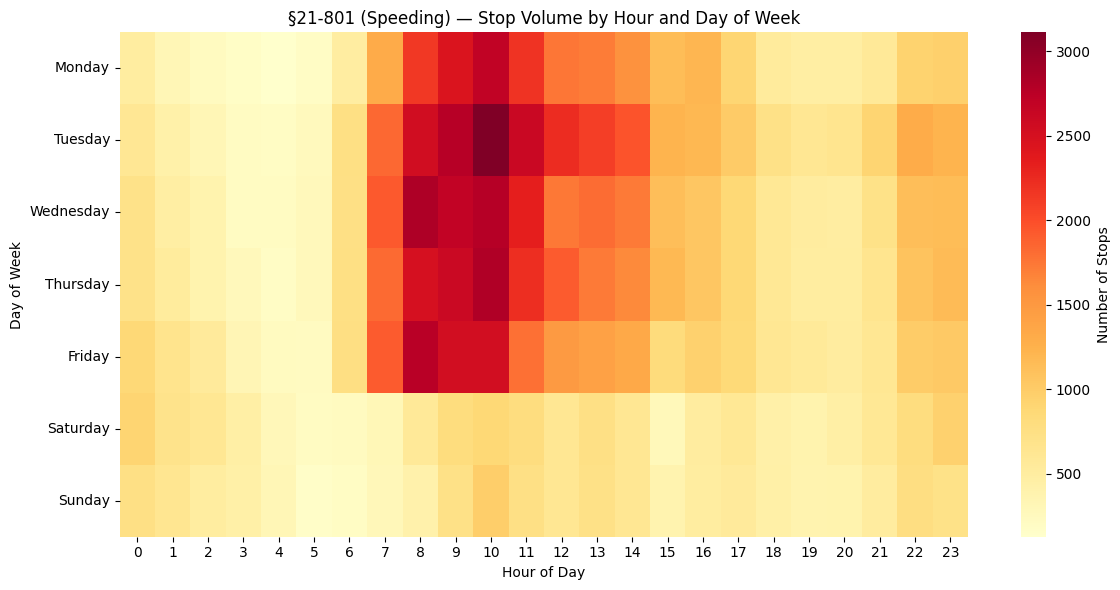

C:\Users\diazk\AppData\Local\Temp\ipykernel_24352\1862540949.py:35: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



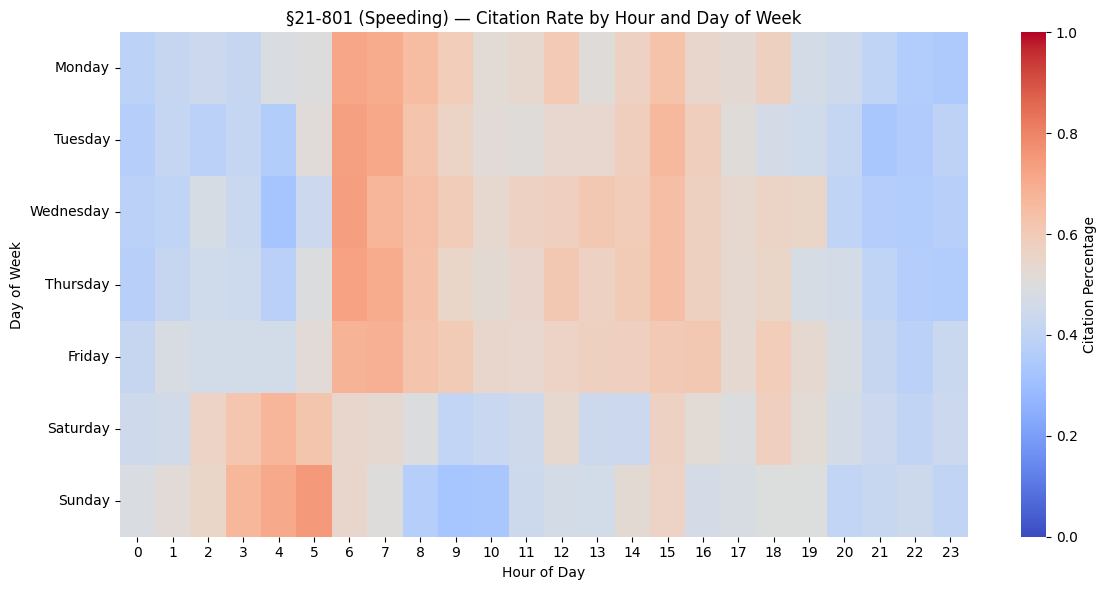

In [47]:
# --- Filter speeding charges (21-801%) ---
speed = df[df["Charge"].astype(str).str.startswith("21-801")].copy()

# --- Extract date/time fields ---
speed["Date Of Stop"] = pd.to_datetime(speed["Date Of Stop"], errors="coerce")
speed["Time Of Stop"] = pd.to_datetime(speed["Time Of Stop"], errors="coerce")
speed["Hour"] = speed["Time Of Stop"].dt.hour
speed["DayOfWeek"] = speed["Date Of Stop"].dt.day_name()

# Weekday ordering
day_order = ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]
speed["DayOfWeek"] = pd.Categorical(speed["DayOfWeek"], categories=day_order, ordered=True)

# --- 1. Stop Volume ---
volume = (
    speed.groupby(["DayOfWeek","Hour"])
    .size()
    .reset_index(name="Count")
)

volume_matrix = volume.pivot(index="DayOfWeek", columns="Hour", values="Count")

plt.figure(figsize=(12,6))
sns.heatmap(volume_matrix, cmap="YlOrRd", cbar_kws={"label": "Number of Stops"})
plt.title("§21-801 (Speeding) — Stop Volume by Hour and Day of Week")
plt.xlabel("Hour of Day")
plt.ylabel("Day of Week")
plt.tight_layout()
plt.show()

# --- 2. Citation Rate (Citation / Total) ---
speed["isCitation"] = (speed["Violation Type"] == "Citation").astype(int)

citation_rate = (
    speed.groupby(["DayOfWeek","Hour"])["isCitation"]
    .mean()
    .reset_index(name="CitationRate")
)

rate_matrix = citation_rate.pivot(index="DayOfWeek", columns="Hour", values="CitationRate")

plt.figure(figsize=(12,6))
sns.heatmap(
    rate_matrix,
    cmap="coolwarm",
    vmin=0, vmax=1,
    cbar_kws={"label": "Citation Percentage"}
)
plt.title("§21-801 (Speeding) — Citation Rate by Hour and Day of Week")
plt.xlabel("Hour of Day")
plt.ylabel("Day of Week")
plt.tight_layout()
plt.show()


Speeding charges appear to be more common during morning commute times. They are also more heavily enforced during those hours.

In [48]:
agency_counts = df.groupby(["Agency","Violation Type"]).size().unstack(fill_value=0)
agency_counts["Total"] = agency_counts.sum(axis=1)
agency_counts["Pct_Citation"] = agency_counts["Citation"] / agency_counts["Total"]

agency_counts.sort_values("Pct_Citation", ascending=False)


Violation Type,Citation,ESERO,SERO,Warning,Total,Pct_Citation
Agency,,,,,,
MCP,497615,51123,922,468974,1018634,0.488512


In [49]:
subagency = df.groupby(["SubAgency","Violation Type"]).size().unstack(fill_value=0)
subagency["Total"] = subagency.sum(axis=1)
subagency["Pct_Citation"] = subagency["Citation"] / subagency["Total"]

subagency.sort_values("Pct_Citation", ascending=False)


Violation Type,Citation,ESERO,SERO,Warning,Total,Pct_Citation
SubAgency,,,,,,
"2nd district, Bethesda",84528,6311,170,58796,149805,0.564254
"3rd district, Silver Spring",114343,11384,149,86450,212326,0.538526
Headquarters and Special Operations,18959,2872,22,13811,35664,0.531600
"4th district, Wheaton",118883,11978,253,117582,248696,0.478025
"5th district, Germantown",52226,5698,27,57101,115052,0.453934
"1st district, Rockville",51026,4779,120,63840,119765,0.426051
"6th district, Gaithersburg / Montgomery Village",57650,8101,181,71394,137326,0.419804


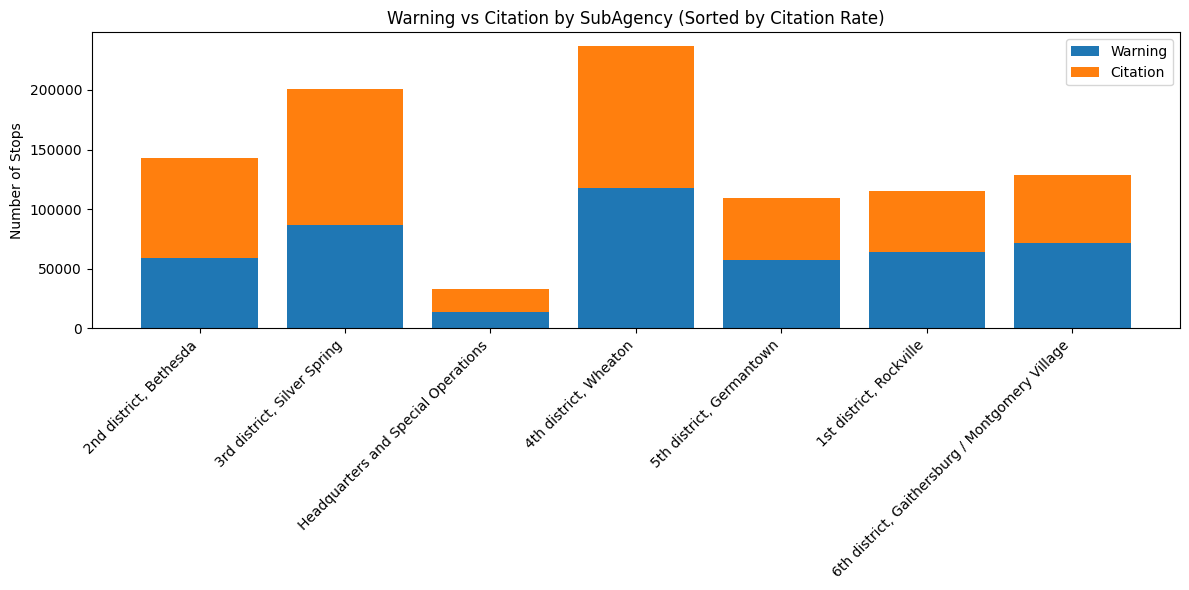

In [54]:
# Sort by citation percentage
sub_sorted = subagency.sort_values("Pct_Citation", ascending=False)

plt.figure(figsize=(12,6))
plt.bar(sub_sorted.index.astype(str), sub_sorted["Warning"], label="Warning")
plt.bar(sub_sorted.index.astype(str), sub_sorted["Citation"],
        bottom=sub_sorted["Warning"], label="Citation")

plt.xticks(rotation=45, ha="right")
plt.title("Warning vs Citation by SubAgency (Sorted by Citation Rate)")
plt.ylabel("Number of Stops")
plt.legend()
plt.tight_layout()
plt.show()


There do seem to be enforcement variations by sub-agency. However, the differences seem small. 2nd district, 3rd district, and HQ give noticeably more citations that warnings. 5th, 1st, and 6th districts appear to give more warnings than citations. 

In [53]:
bool_cols = ["Accident", "Belts", "Personal Injury", "Property Damage", "Fatal", "Commercial License", "HAZMAT", "Commercial Vehicle", "Alcohol", "Work Zone", "Contributed To Accident"]

results = {}

for col in bool_cols:
    tmp = df[df[col].notna()].copy()
    tmp[col] = tmp[col].astype(str)

    rate = (
        tmp.groupby(col)["Violation Type"]
        .apply(lambda x: (x == "Citation").mean())
    )

    results[col] = rate.to_dict()

pd.DataFrame(results).T


,No,Yes
Accident,0.488512,NaN
Belts,0.484283,0.601425
Personal Injury,0.483191,0.943520
Property Damage,0.480199,0.926936
Fatal,0.488470,0.690141
Commercial License,0.487061,0.533772
HAZMAT,0.488541,0.243697
Commercial Vehicle,0.489773,0.295832
Alcohol,0.487631,0.939990
Work Zone,0.488484,0.634518


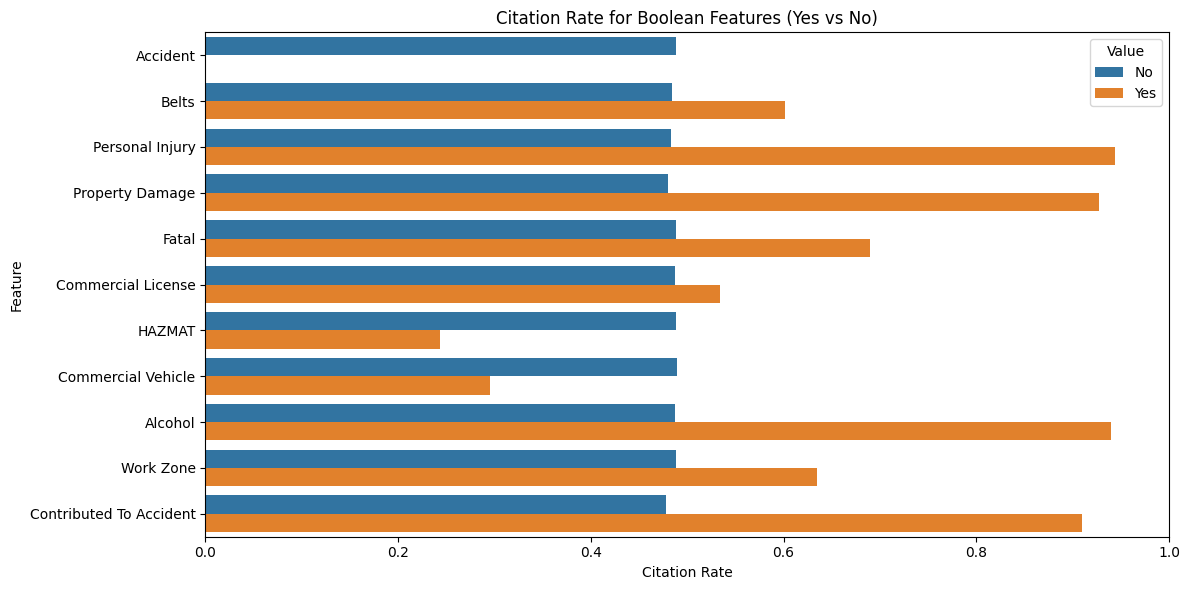

In [55]:
# Convert results to DataFrame
bool_df = pd.DataFrame(results).T

# Reformat for plotting
melted = bool_df.reset_index().melt(id_vars="index", var_name="FlagValue", value_name="CitationRate")
melted = melted.rename(columns={"index": "Feature"})

plt.figure(figsize=(12,6))
sns.barplot(data=melted, x="CitationRate", y="Feature", hue="FlagValue")

plt.title("Citation Rate for Boolean Features (Yes vs No)")
plt.xlabel("Citation Rate")
plt.ylabel("Feature")
plt.xlim(0, 1)
plt.legend(title="Value")
plt.tight_layout()
plt.show()


The boolean columns appear to be very rarely used, however when they do happen to be checked they signal an almost certain citation, aside from HAZMAT and commercial vehicles, in which cases they actually decrease citation rates